In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuron import h, gui
import os
import brainunit as u 
from GOL import Golgi_morpho_1
## load mod
current_dir = os.getcwd()
mod_path = os.path.join(current_dir, '/golgi_NEURON/mod_gol')
os.system(f'nrnivmodl {mod_path}')

--No graphics will be displayed.


/home/swl/braincell/examples/golgi_model/golgi_NEURON
Arg Error: "/golgi_NEURON/mod_gol" is not a folder or mod file name or prefix

  Mod file, folder args: "/golgi_NEURON/mod_gol"


/home/swl/anaconda3/envs/braincell/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Traceback (most recent call last):
  File "/home/swl/anaconda3/envs/braincell/bin/nrnivmodl", line 114, in <module>
    subprocess.check_call([exe, *sys.argv[1:]])
  File "/home/swl/anaconda3/envs/braincell/lib/python3.10/subprocess.py", line 369, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['/home/swl/anaconda3/envs/braincell/lib/python3.10/site-packages/neuron/.data/bin/nrnivmodl', '/golgi_NEURON/mod_gol']' returned non-zero exit status 1.


256

## NEURON

In [2]:
## run
def NeuronRun(cell, stim, tstop, dt, v_init):
    ## create record vector
    t_vec = h.Vector()
    t_vec.record(h._ref_t)
    v_vecs = []

    for sec in h.allsec():
        for seg in sec:
            v_vec = h.Vector()
            v_vec.record(seg._ref_v)
            v_vecs.append(v_vec)

    ## simulation
    h.celsius = 6.3
    h.dt = dt
    h.v_init = v_init
    h.finitialize(v_init)
    h.continuerun(tstop)
    return t_vec, v_vecs

def step_stim(cell, delay, dur, amp):
    stim = h.IClamp(cell.soma[0](0.5))
    stim.delay = delay
    stim.dur = dur
    stim.amp = amp
    return stim


5389 lines read


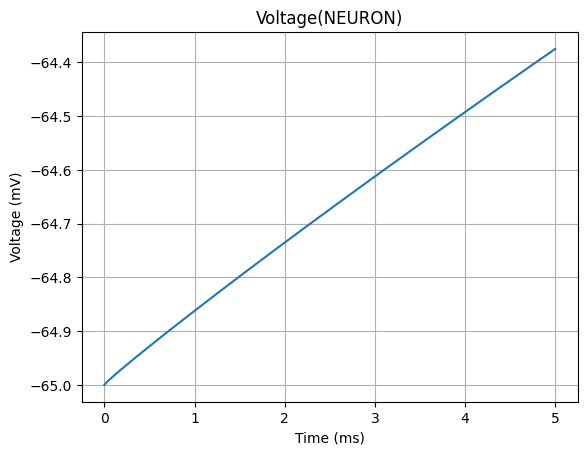

In [3]:
cell = Golgi_morpho_1(el=-55, gl=1, ghcn1=0, ghcn2=0, ena=60, gna=0, ek=-80, gkv11=0, gkv34=0, gkv43=0)

#cell.axon[0].disconnect()
#cell.dend[0].disconnect()
# cell.dend[33].disconnect()
# cell.dend[106].disconnect()
# cell.dend[113].disconnect()
# cell.dend[122].disconnect()
# cell.dend[125].disconnect()
# cell.dend[130].disconnect()
# cell.dend[133].disconnect()
# cell.dend[134].disconnect()
# cell.dend[141].disconnect()
# cell.dend[142].disconnect()

stim = step_stim(cell, delay=0, dur=5, amp=0.00)
t_vec, v_vecs = NeuronRun(cell=cell, stim=stim, tstop=5, dt=0.01, v_init=-65)

for i in range(1):
    plt.plot(t_vec, v_vecs[i], label=f'sec_{i}')
#plt.legend()
plt.xlabel('Time (ms)') 
plt.ylabel('Voltage (mV)')
plt.title('Voltage(NEURON)')
plt.grid(True)
plt.show()



## 读取数据

In [4]:
from neuron import h
import numpy as np

def extract_section_points(sec):
    """
    从 NEURON 的 section 中提取三维坐标和直径信息，返回形状为 (N, 4) 的 NumPy 数组
    """
    n3d = int(sec.n3d())
    if n3d < 2:
        raise ValueError(f"Section {sec.name()} has less than 2 3D points.")
    
    points = []
    for i in range(n3d):
        x = sec.x3d(i)
        y = sec.y3d(i)
        z = sec.z3d(i)
        diam = sec.diam3d(i)
        points.append([x, y, z, diam])
    
    return np.array(points)

# 获取所有 section 和它们的索引
all_sections = list(h.allsec())
section_index = {sec: i for i, sec in enumerate(all_sections)}

# 储存所有 section 信息
section_info_list = []
connection_list = []

for sec in all_sections:
    try:
        sec_idx = section_index[sec]
        node_pre = extract_section_points(sec)
        Ra = sec.Ra
        cm = sec.cm
        nseg = int(sec.nseg)
        
        #  无父节点默认值
        parent_index = -1
        connection_site = -1

        parent_sec = sec.parentseg().sec if sec.parentseg() else None

        if parent_sec is not None:
            connection_site = sec.parentseg().x
            parent_index = section_index[parent_sec]

        section_info = {
            'Ra': Ra , #* u.ohm * u.cm
            'cm': cm , #  * u.uF/(u.cm**2)
            'nseg': nseg, 
            'points': node_pre,  # shape: (N, 4)
        }
        
        if parent_index!=-1:
            connection_list.append((f'section_{sec_idx}',  f'section_{parent_index}', connection_site))

        section_info_list.append(section_info)

    except Exception as e:
        print(f"Skipping section {sec.name()} due to error: {e}")


## 保存数据

In [5]:
new_dict = {}

for i, section_info in enumerate(section_info_list):
    key = f'section_{i}'
    new_dict[key] = section_info

np.save('golgi_info.npy', new_dict)
np.save('../golgi_info.npy', new_dict)

import json
#np.save('../golgi_connection',connection_list)
with open('../golgi_connection.json', 'w') as file:
    json.dump(connection_list, file)


## 获得soma，axon和dend的segment序号

In [ ]:
def get_segment_indices(section_type):
    index = 0
    segment_indices = []
    for sec in h.allsec():
        if section_type in sec.name():
            for seg in sec:
                segment_indices.append(index)
                index += 1
        else:
            index += sec.nseg
    return segment_indices

def get_dend_indices():
    index_dend_sec = 0
    index_total_seg = 0
    dend_basal = []
    dend_apical = []
    for sec in h.allsec():
        if 'dend' in sec.name():
            if (0 <= index_dend_sec <= 3) or (16 <= index_dend_sec <= 17) or (33 <= index_dend_sec <= 41) or index_dend_sec == 84 or (105 <= index_dend_sec <= 150):
                for seg in sec:
                    dend_basal.append(index_total_seg)
                    index_total_seg += 1
            if (4 <= index_dend_sec <= 15) or (18 <= index_dend_sec <= 32) or (42 <= index_dend_sec <= 83) or (85 <= index_dend_sec <= 104):
                for seg in sec:
                    dend_apical.append(index_total_seg)
                    index_total_seg += 1
            index_dend_sec += 1
        else:
            index_total_seg+= sec.nseg

    return dend_basal, dend_apical

In [ ]:
index_soma = get_segment_indices('soma')
index_axon = get_segment_indices('axon')
index_dend_basal, index_dend_apical = get_dend_indices()

index_dict = {
    'index_soma': index_soma,
    'index_axon': index_axon,
    'index_dend_basal': index_dend_basal,
    'index_dend_apical': index_dend_apical,
}

np.save('../golgi_index.npy', index_dict)

## 生成电阻和表面积函数

In [ ]:
# ## with unit
# def calculate_total_resistance_and_area(points, resistivity=1.0):
#     """
#     计算由 N 个坐标点形成的 N - 1 个圆台的总电阻和总侧面积
#     :param points: 包含 N 个点的列表，每个点是 (x, y, z, diam) 组成的 NumPy 数组
#     :param resistivity: 电阻率，默认为 1.0
#     :return: 总电阻和总侧面积的元组
#     """

#     xyz = points[:, :3]  # 取前三列 (x, y, z)
#     diameters = points[:, 3]  # 取直径列
    
#     # 计算相邻点的欧几里得距离
#     heights = u.math.linalg.norm(u.math.diff(xyz, axis=0), axis=1)
    
#     # 计算相邻点的半径
#     r1 = diameters[:-1] / 2
#     r2 = diameters[1:] / 2
    
#     # 计算母线长度 (斜高)
#     slant_heights = u.math.sqrt(heights**2 + (r2 - r1)**2)
    
#     # 计算侧面积
#     surface_areas = u.math.pi * (r1 + r2) * slant_heights
#     total_surface_area = u.math.sum(surface_areas)
    
#     # 计算电阻
#     resistances = resistivity * heights / (np.pi * r1 * r2)
#     total_resistance = np.sum(resistances)
    
#     return total_resistance, total_surface_area

# def compute_line_ratios(points):
#     """
#     计算三维坐标点在线段总长度中的比例（ratio）
#     :param points: 形状 (N, 3) 的 NumPy 数组，每行是一个三维坐标点 (x, y, z)
#     :return: 形状 (N,) 的 NumPy 数组，每个点在线段中的比例
#     """

#     # 计算相邻点的欧式距离
#     segment_lengths = u.math.linalg.norm(u.math.diff(points, axis=0), axis=1)

#     # 计算总长度
#     total_length = u.math.sum(segment_lengths)

#     if u.get_magnitude(total_length) == 0:
#         return u.math.zeros(len(points))  # 处理特殊情况，所有点重合

#     # 计算累计长度，并归一化
#     cumulative_lengths = np.insert(np.cumsum(u.get_magnitude(segment_lengths)), 0, 0)  # 在开头插入0
#     ratios = cumulative_lengths / u.get_magnitude(total_length)  # 归一化

#     return ratios

# def find_ratio_interval(ratios, target_ratio):
#     """
#     在 ratio 列表中，找到 target_ratio 落在哪两个相邻点之间。
#     如果 target_ratio 是边界（0 或 1），会返回合法范围内的索引。

#     :param ratios: 形状 (N,) 的递增 NumPy 数组，每个点在线段中的比例，默认包含 0 和 1
#     :param target_ratio: 目标比例，范围在 [0,1] 之间
#     :return: (lower_index, upper_index) - 目标比例所在的两个相邻索引
#     """
    
#     N = len(ratios)

#     if target_ratio <= ratios[0]:
#         return 0, 1
#     elif target_ratio >= ratios[-1]:
#         return N - 2, N - 1
#     else:
#         idx = u.math.searchsorted(ratios, target_ratio) - 1
#         return idx, idx + 1


# def generate_interpolated_nodes(node_pre, nseg):
#     """
#     生成 2*nseg+1 个插值点，并计算它们的坐标和直径。
    
#     :param node_pre: (N, 4) 的 NumPy 数组，每行是 (x, y, z, diam)
#     :param nseg: 内部分割的 segment 个数，最终会生成 2*nseg+1 个点
#     :return: 形状 (2*nseg+1, 4) 的插值后点集 node_after
#     """

#     xyz_pre = node_pre[:, :3]  # 取前三列 (x, y, z)
#     diam_pre = node_pre[:, 3]  # 取直径列

#     # 1. 计算 node_pre 的 ratio
#     ratios_pre = compute_line_ratios(xyz_pre)

#     # 2. 生成 2*nseg+1 个均分 ratio（包含 0 和 1）
#     ratios_new = u.math.linspace(0, 1, 2*nseg + 1)

#     # 3. 对每个新 ratio 进行插值计算
#     xyz_new = []
#     diam_new = []

#     for r in ratios_new:
#         # 找到 r 在 node_pre 的 ratio 中的相邻索引
#         i1, i2 = find_ratio_interval(ratios_pre, r)
#         # 取出相邻点的信息
#         r1, r2 = ratios_pre[i1], ratios_pre[i2]
#         x1, y1, z1 = xyz_pre[i1]
#         x2, y2, z2 = xyz_pre[i2]
#         d1, d2 = diam_pre[i1], diam_pre[i2]

#         # 计算插值
#         alpha = (r - r1) / (r2 - r1) if r2 != r1 else 0  # 避免除零
#         x_new = x1 + alpha * (x2 - x1)
#         y_new = y1 + alpha * (y2 - y1)
#         z_new = z1 + alpha * (z2 - z1)
#         d_new = d1 + alpha * (d2 - d1)

#         xyz_new.append([x_new, y_new, z_new])
#         diam_new.append(d_new)

#     # 4. 组合为最终的 node_after
#     node_after = u.math.column_stack([xyz_new, diam_new])

#     return node_after

# def compute_resistance_and_conductance(node_pre, nseg, resistivity = 100 ):
#     """
#     计算每个 segment 的左电阻 (resistance_left) 和右电导 (conductance_right)。
    
#     :param node_pre: (N, 4) 的 NumPy 数组，每行是 (x, y, z, diam)
#     :param node_after: (M, 4) 的 NumPy 数组，每行是 (x, y, z, diam)，共 2*nseg+1 个点
#     :param nseg: 需要划分的 segment 数量
#     :return: 每个 segment 的 (resistance_left, conductance_right) 列表
#     """
#     node_after = generate_interpolated_nodes(node_pre, nseg) 

#     # 提取 xyz 和 直径
#     xyz_pre, diam_pre = node_pre[:, :3], node_pre[:, 3]
#     xyz_after, diam_after = node_after[:, :3], node_after[:, 3]

#     # 计算 node_pre 和 node_after 的 ratio
#     ratios_pre = compute_line_ratios(xyz_pre)
#     ratios_after = compute_line_ratios(xyz_after)

#     results = []

#     # 以步长 2 遍历 node_after 的 (i, i+1, i+2)，保证最终有 nseg 组数据
#     for i in range(0, len(node_after) - 2, 2):
#         r1, r2, r3 = ratios_after[i], ratios_after[i+1], ratios_after[i+2]

#         # 计算左电阻 (i → i+1)，保证端点包含在内
#         mask_left = (ratios_pre > r1) & (ratios_pre < r2)
#         selected_left = u.math.vstack([node_after[i], node_pre[mask_left], node_after[i+1]])

#         # 计算右电阻 (i+1 → i+2)，保证端点包含在内
#         mask_right = (ratios_pre > r2) & (ratios_pre < r3)
#         selected_right = u.math.vstack([node_after[i+1], node_pre[mask_right], node_after[i+2]])

#         # 计算电阻
#         resistance_left, surface_area_left = calculate_total_resistance_and_area(selected_left, resistivity)
#         resistance_right, surface_area_right = calculate_total_resistance_and_area(selected_right, resistivity)
        
#         results.append((surface_area_left + surface_area_right, resistance_left, resistance_right))

#     return results


In [ ]:
def calculate_total_resistance_and_area(points, resistivity=1.0):
    """
    计算由 N 个坐标点形成的 N - 1 个圆台的总电阻和总侧面积
    :param points: 包含 N 个点的列表，每个点是 (x, y, z, diam) 组成的 NumPy 数组
    :param resistivity: 电阻率，默认为 1.0
    :return: 总电阻和总侧面积的元组
    """
    points = np.asarray(points)  # 确保 points 是 NumPy 数组
    xyz = points[:, :3]  # 取前三列 (x, y, z)
    diameters = points[:, 3]  # 取直径列
    
    # 计算相邻点的欧几里得距离
    heights = np.linalg.norm(np.diff(xyz, axis=0), axis=1)
    
    # 计算相邻点的半径
    r1 = diameters[:-1] / 2
    r2 = diameters[1:] / 2
    
    # 计算母线长度 (斜高)
    slant_heights = np.sqrt(heights**2 + (r2 - r1)**2)
    
    # 计算侧面积
    surface_areas = np.pi * (r1 + r2) * slant_heights
    total_surface_area = np.sum(surface_areas)
    
    # 计算电阻
    resistances = resistivity * heights / (np.pi * r1 * r2)
    total_resistance = np.sum(resistances)
    
    return total_resistance, total_surface_area

def compute_line_ratios(points):
    """
    计算三维坐标点在线段总长度中的比例（ratio）
    :param points: 形状 (N, 3) 的 NumPy 数组，每行是一个三维坐标点 (x, y, z)
    :return: 形状 (N,) 的 NumPy 数组，每个点在线段中的比例
    """
    points = np.asarray(points)  

    # 计算相邻点的欧式距离
    segment_lengths = np.linalg.norm(np.diff(points, axis=0), axis=1)

    # 计算总长度
    total_length = np.sum(segment_lengths)

    if total_length == 0:
        return np.zeros(len(points))  # 处理特殊情况，所有点重合

    # 计算累计长度，并归一化
    cumulative_lengths = np.insert(np.cumsum(segment_lengths), 0, 0)  
    ratios = cumulative_lengths / total_length 

    return ratios

def find_ratio_interval(ratios, target_ratio):
    """
    在 ratio 列表中，找到 target_ratio 落在哪两个相邻点之间。
    如果 target_ratio 是边界（0 或 1），会返回合法范围内的索引。

    :param ratios: 形状 (N,) 的递增 NumPy 数组，每个点在线段中的比例，默认包含 0 和 1
    :param target_ratio: 目标比例，范围在 [0,1] 之间
    :return: (lower_index, upper_index) - 目标比例所在的两个相邻索引
    """
    ratios = np.asarray(ratios)
    N = len(ratios)

    if target_ratio <= ratios[0]:
        return 0, 1
    elif target_ratio >= ratios[-1]:
        return N - 2, N - 1
    else:
        idx = np.searchsorted(ratios, target_ratio) - 1
        return idx, idx + 1


def generate_interpolated_nodes(node_pre, nseg):
    """
    生成 2*nseg+1 个插值点，并计算它们的坐标和直径。
    
    :param node_pre: (N, 4) 的 NumPy 数组，每行是 (x, y, z, diam)
    :param nseg: 内部分割的 segment 个数，最终会生成 2*nseg+1 个点
    :return: 形状 (2*nseg+1, 4) 的插值后点集 node_after
    """
    node_pre = np.asarray(node_pre)  # 确保是 NumPy 数组
    xyz_pre = node_pre[:, :3]  # 取前三列 (x, y, z)
    diam_pre = node_pre[:, 3]  # 取直径列

    # 1. 计算 node_pre 的 ratio
    ratios_pre = compute_line_ratios(xyz_pre)
    #print('ratio',ratio_pre)
    # 2. 生成 2*nseg+1 个均分 ratio（包含 0 和 1）
    ratios_new = np.linspace(0, 1, 2*nseg + 1)
    # 3. 对每个新 ratio 进行插值计算
    xyz_new = []
    diam_new = []

    for r in ratios_new:
        # 找到 r 在 node_pre 的 ratio 中的相邻索引
        i1, i2 = find_ratio_interval(ratios_pre, r)
        #print('i1, i2=',i1,i2)
        # 取出相邻点的信息
        r1, r2 = ratios_pre[i1], ratios_pre[i2]
        x1, y1, z1 = xyz_pre[i1]
        x2, y2, z2 = xyz_pre[i2]
        d1, d2 = diam_pre[i1], diam_pre[i2]

        # 计算插值
        alpha = (r - r1) / (r2 - r1) if r2 != r1 else 0  # 避免除零
        x_new = x1 + alpha * (x2 - x1)
        y_new = y1 + alpha * (y2 - y1)
        z_new = z1 + alpha * (z2 - z1)
        d_new = d1 + alpha * (d2 - d1)

        xyz_new.append([x_new, y_new, z_new])
        diam_new.append(d_new)

    # 4. 组合为最终的 node_after
    node_after = np.column_stack([xyz_new, diam_new])

    return node_after

def compute_resistance_and_conductance(node_pre, nseg, resistivity = 100 ):
    """
    计算每个 segment 的左电阻 (resistance_left) 和右电导 (conductance_right)。
    
    :param node_pre: (N, 4) 的 NumPy 数组，每行是 (x, y, z, diam)
    :param node_after: (M, 4) 的 NumPy 数组，每行是 (x, y, z, diam)，共 2*nseg+1 个点
    :param nseg: 需要划分的 segment 数量
    :return: 每个 segment 的 (resistance_left, conductance_right) 列表
    """
    node_pre = np.asarray(node_pre)
    node_after = generate_interpolated_nodes(node_pre, nseg) 
    node_after = np.asarray(node_after)

    # 提取 xyz 和 直径
    xyz_pre, diam_pre = node_pre[:, :3], node_pre[:, 3]
    xyz_after, diam_after = node_after[:, :3], node_after[:, 3]

    # 计算 node_pre 和 node_after 的 ratio
    ratios_pre = compute_line_ratios(xyz_pre)
    ratios_after = np.linspace(0, 1, 2*nseg + 1) #compute_line_ratios(xyz_after)
    results = []

    # 以步长 2 遍历 node_after 的 (i, i+1, i+2)，保证最终有 nseg 组数据
    for i in range(0, len(node_after) - 2, 2):
        r1, r2, r3 = ratios_after[i], ratios_after[i+1], ratios_after[i+2]
        #r1, r2, r3 = 0, 0.54, 1
        # 计算左电阻 (i → i+1)，保证端点包含在内
        
        mask_left = (ratios_pre >= r1) & (ratios_pre < r2)
        selected_left = np.vstack([node_after[i], node_pre[mask_left], node_after[i+1]])
        # print(mask_left)
        # print(selected_left.shape)
        # 计算右电阻 (i+1 → i+2)，保证端点包含在内
        # print('ratio_after',ratios_after)
        print('ratio_pre',ratios_pre)
        # print('r3=',r3)
        # print(ratios_pre[-1])
        mask_right = (ratios_pre > r2) & (ratios_pre < r3)
        selected_right = np.vstack([node_after[i+1], node_pre[mask_right], node_after[i+2]])
        # print(selected_right.shape)
        # print(mask_right)
        # 计算电阻
        resistance_left, surface_area_left = calculate_total_resistance_and_area(selected_left, resistivity)
        resistance_right, surface_area_right = calculate_total_resistance_and_area(selected_right, resistivity)
        # print( surface_area_left)
        # print( surface_area_right)
        results.append((surface_area_left + surface_area_right, resistance_left, resistance_right))

    return results


In [ ]:
import brainunit as u
new_dict = np.load('golgi_info.npy',allow_pickle= True).item()

Area = []
g_left = []
g_right = []
nseg_list = []
connection_sec = []

for i,values in enumerate(new_dict.values()):

    points = values['points']
    nseg = values['nseg']
    Ra = values['Ra']
    nseg = values['nseg']
    connection = values['connection']
    
    areas_i, g_l_i, g_r_i = zip(*compute_resistance_and_conductance(points, nseg, resistivity=Ra))

    Area.extend(areas_i)
    g_left.extend(g_l_i)
    g_right.extend(g_r_i)
    
    nseg_list.append(nseg)
    connection_sec.append(connection)
    print(areas_i)


## get adj matrix

In [ ]:
sec_to_segs = {}
seg_counter = 0
n_compartment = np.sum(nseg_list)

# 生成 sec_to_segs 字典
for sec_index, num_segs in enumerate(nseg_list):
    sec_to_segs[sec_index] = list(range(seg_counter, seg_counter + num_segs))
    seg_counter += num_segs

parent_indices = []
site_list = []

# 计算 connection_seg
for sec_index, seg_list in sec_to_segs.items():
    for relative_position, seg in enumerate(seg_list):
        if relative_position > 0:
            parent_index = seg - 1
            site = 1
        else:
            parent_sec = connection_sec[sec_index][1]
            parent_sec_site = connection_sec[sec_index][2]
            if parent_sec != -1:
                position_in_parent_sec = int(np.ceil(nseg_list[parent_sec] * parent_sec_site) - 1)
                parent_index = sec_to_segs[parent_sec][position_in_parent_sec]
                site = nseg_list[parent_sec] * parent_sec_site - position_in_parent_sec
            else:
                parent_index = -1
                site = -1

        parent_indices.append(parent_index)
        site_list.append(site)

connection_seg = [(i, parent_indices[i], site_list[i]) for  i in range(n_compartment)]



## resistance_matrix

In [ ]:
def init_coupling_weight_nodes(g_left, g_right, connection):

    parent_child_dict = {}
    processed_connection = []
    for child, parent, connection_site in connection:
        processed_connection.append([int(child), int(parent), float(connection_site)])

    for child, parent, connection_site in processed_connection:
        if parent not in parent_child_dict:
            parent_child_dict[parent] = {0.5: [], 1: []}
        if connection_site == 0.5:
            parent_child_dict[parent][0.5].append(child)
        elif connection_site == 1:
            parent_child_dict[parent][1].append(child)

    num_segments = len(connection)

    axial_conductance_matrix = np.zeros((num_segments, num_segments)) 

    for parent, children_dict in parent_child_dict.items():
        if parent != -1:
            # 处理连接位点为 1 的 children
            children_at_1 = children_dict[1]
            #print('parent=', parent)
            #print("child = ", children_at_1)
            all_nodes_at_1 = [parent] + children_dict[1]
            denominator_at_1 = np.sum(np.array([g_left[i] for i in children_at_1])) +  g_right[parent]
            for i in all_nodes_at_1:
                for j in all_nodes_at_1:
                    if i != j:
                        if i ==parent:
                            axial_conductance_matrix[i, j] = g_right[i] * g_left[j] / denominator_at_1
                        elif j ==parent:
                            axial_conductance_matrix[i, j] = g_left[i] * g_right[j] / denominator_at_1
                        else:
                            axial_conductance_matrix[i, j] = g_left[i] * g_left[j] / denominator_at_1

            # 处理连接位点为 0.5 的 children
            children_at_0_5 = children_dict[0.5]
            for child in children_at_0_5:
                axial_conductance_matrix[parent, child] = g_left[child]
                axial_conductance_matrix[child, parent] = g_left[child]
                            
    return axial_conductance_matrix

In [ ]:
for j,sec in enumerate(h.allsec()):

    for seg in sec:
        if j == 1:
            #sec.nseg =1
            #print(seg.area())
            #print(sec.n3d())
            print(seg.ri())
            points_axon0 = []
            for i in range(int(sec.n3d())):
                x = sec.x3d(i)
                y = sec.y3d(i)
                z = sec.z3d(i)
                diam = sec.diam3d(i)
                points_axon0.append([x, y, z, diam])
                Ra = sec.Ra
        else:
            print('R=',seg.ri())

In [ ]:
points_axon0 = np.array(points_axon0)
print(points_axon0.shape)
R, A = calculate_total_resistance_and_area(points=points_axon0[:54,:], resistivity = Ra )
print(R,A)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_points(points):
    # 将点转换为 NumPy 数组
    points = np.array(points)
    
    # 创建一个三维坐标轴
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # 提取 x, y, z 坐标
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    
    # 绘制三维散点图
    ax.scatter(x, y, z, c='r', marker='o')
    
    # 设置坐标轴标签
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # 显示图形
    plt.show()


In [ ]:
plot_3d_points(points_axon0)